In the notebook `KBDL_December2nd_optim-crossval`, it was noticed that adding a local short-timescale component to the predictive covariance
allowed the maximum a posteriori imputation to fit the true temperatures very closely. The question then is whether such a component could help the imputations more generally.
We will run the same Stan imputations twice: once with the normal predictive covariance, and then with an added local component.
The hope is that the imputations will fit the truth more closely.

In [1]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=120.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=120.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [2]:
using Printf
using DataFrames
using JLD
using Dates
using GaussianProcesses: set_params!
import JSON
using Dates
using PDMats
using LinearAlgebra
using Statistics
using StatsBase: midpoints, Weights
using Distributions
using GaussianProcesses
using CmdStan

GPmodel="maternlocal"
ICAO="KBDL"
data_dir="../data"
save_dir="/Volumes/Samsung250GB/saved"
k_nearest=5

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/alternative_depots/climate/compiled/v1.1/GaussianProcesses/izlaf.ji for GaussianProcesses [891a1506-143c-57d2-908e-e1f8e92e6de9]
└ @ Base loading.jl:1184


5

In [3]:
using Revise
import TempModel

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/alternative_depots/climate/compiled/v1.1/TempModel/5V5SX.ji for TempModel [429a4ede-8e99-57b3-891e-c3971593d88c]
└ @ Base loading.jl:1184


In [4]:
module Batch
    using TempModel
    import PyPlot; plt=PyPlot
    using LaTeXStrings
    using DataFrames
    using Dates
    using Distributions
    using PDMats
    using LinearAlgebra
    using Printf
    ;
    src_dir = dirname(pathof(TempModel))
    include(joinpath(src_dir, "batch_diagnostics.jl"))
    include(joinpath(src_dir, "plot_diagnostics.jl"))
    include(joinpath(src_dir, "infermean.jl"))
#     include(joinpath(src_dir, "plot_map.jl"))
end

Main.Batch

In [8]:
# load kernel hyperparameters from JSON file
json_fname = @sprintf("hyperparams_%s_%s.json", GPmodel, ICAO)
json_filepath = joinpath(save_dir, "fitted_kernel", "crossval", GPmodel, json_fname)
open(json_filepath, "r") do io
    global output_dictionary = JSON.parse(io)
end
@assert output_dictionary["test_ICAO"] == ICAO

epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=data_dir, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=data_dir)

test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
@assert nrow(test_station) == 1
USAF = test_station[1, :USAF]
WBAN = test_station[1, :WBAN]

isd_nearest_and_test = TempModel.find_nearest(isd_wData, USAF, WBAN, k_nearest)

hourly_cat=TempModel.read_Stations(isd_nearest_and_test; data_dir=data_dir)
itest=1 # first row of isd_nearest_and_test is the test station
timezoneGMT = -5 # Georgia
# timezoneGMT = -7 # Arizona
local_time(ts) = ts - Hour(timezoneGMT)
ilocaltime = circshift(1:24, -timezoneGMT)
;

In [9]:
hr_measure = Hour(17)
TnTx = TempModel.test_data(hourly_cat, itest, hr_measure)
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
# add column to test data for TnTx (useful for plotting)
hourly_test = join(hourly_test, TnTx, on=:ts_day)
;

# Running Stan

In [10]:
test_fw = Batch.FittingWindow(Date(2015,5,2),Date(2015,7,14))
nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, save_dir; crossval=true)
date_start = Date(2015,5,28)
impute_window = Day(7)
stan_data, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=50.0, epsilon=0.1) # steep k, permissive epsilon
imputation_model = TempModel.get_imputation_model(;seed=42) # Stan model
;

=====> /Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks



In [11]:
@time sim1 = stan(imputation_model, [stan_data], summary=true, diagnostics=false);


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)


If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.but if this warning occurs often then your model may be eit

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

but if this warning occurs often then your model may be 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[4] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e


Calling /usr/local/Cellar/cmdstan/2.17.0/bin/stansummary to infer across chains.

Inference for Stan model: imputation_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (142, 141, 142, 143) seconds, 9.5 minutes total
Sampling took (109, 109, 109, 109) seconds, 7.3 minutes total

                     Mean     MCSE   StdDev        5%       50%       95%  N_Eff  N_Eff/s    R_hat
lp__             -1.4e+02  3.3e-01  1.2e+01  -1.6e+02  -1.4e+02  -1.3e+02   1239  2.8e+00  1.0e+00
accept_stat__     9.4e-01  1.3e-03  8.0e-02   7.7e-01   9.7e-01   1.0e+00   4000  9.2e+00  1.0e+00
stepsize__        1.5e-02  8.2e-04  1.2e-03   1.3e-02   1.5e-02   1.7e-02    2.0  4.6e-03  4.9e+13
treedepth__       8.0e+00  8.4e-17  5.3e-15   8.0e+00   8.0e+00   8.0e+00   4000  9.2e+00  1.0e+00
n_leapfrog__      2.5e+02  4.9e-14  3.1e-12   2.6e+02   2.6e+02   2.6e+02   4000  9.2e+00  1.0e+00
divergent__       0.0e+00  0.0e+00  0.0e+00   0.0e+

264.519214 seconds (23.92 M allocations: 1.072 GiB, 0.17% gc time)


In [12]:
using AxisArrays
function Chains(samples::AbstractArray{Float64, 3}, names::AbstractVector{S}) where {S<:AbstractString}
    nsamples, ncol, nchains = size(samples)
    chains = AxisArray(samples, Axis{:sample}(1:nsamples), Axis{:param}(names), Axis{:chain}(1:nchains))
    return chains
end
function get_param_names(chains::AxisArray)
    # there should be a more elegant way to obtain the names of an axis
    PARAM = Axis{:param}
    jparam = axisdim(chains, PARAM)
    param_axis = AxisArrays.axes(chains)[jparam]
    param_names = axisvalues(param_axis)[1]
    return param_names
end
function get_temperatures_reparam(chains::AxisArray)
    param_names = get_param_names(chains)
    temp_varnames = [h for h in param_names if startswith(h, "temp_impt.")]
    temp_samples = view(chains, :, Axis{:param}(temp_varnames), :)
    return temp_samples
end
chainsarray = Chains(sim1[2], sim1[3])
@show size(chainsarray)
temp_impute = get_temperatures_reparam(chainsarray);

size(chainsarray) = (1000, 587, 4)


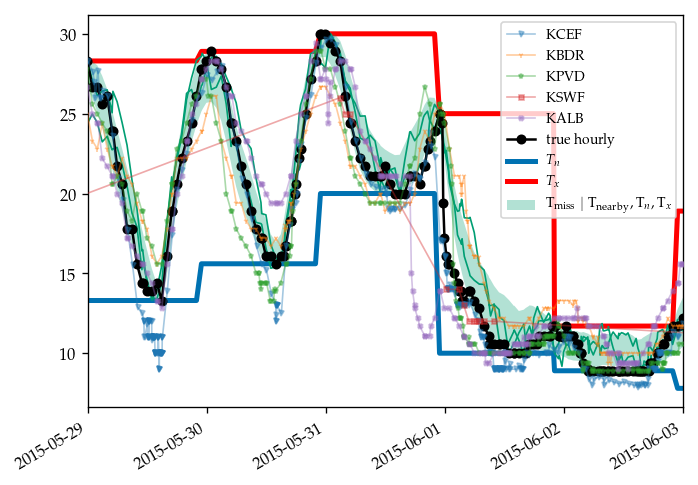

In [13]:
Batch.plot_imputations(ts_window, temp_impute, local_time; plot_mean=false, impt_indices=[250,500])
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,5,29), Date(2015,6,3))
# plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,5,2),DateTime(2015,7,14));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,5,2),DateTime(2015,7,14))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

In [14]:
june1 = hourly_test[hourly_test[:ts_day] .== Date(2015,6,1), :]
true_mean_june1 = mean(june1[:temp])

13.378260869565224

In [15]:
impute_june1 = temp_impute[:,[t ∈ june1[:ts] for t in ts_window],:]
mean(impute_june1) - true_mean_june1 # was 1.77 with Matérn

1.8604801634239045

In [20]:
impute_june1 = temp_impute[
    :, # samples
    [t ∈ june1[:ts] for t in ts_window], # time
    :] # chain
mean(impute_june1) - true_mean_june1

1.8604801634239045

In [21]:
imputedmean       = collect(vec(mean(impute_june1; dims=2)))

4000-element Array{Float64,1}:
 15.055541304347823
 15.134599999999995
 15.203064130434786
 14.05060434782609 
 14.723115217391296
 15.79933804347826 
 16.065752173913047
 15.5683652173913  
 16.24080478260869 
 15.312918913043477
 15.476460869565225
 15.518780434782608
 14.283435217391306
  ⋮                
 15.205681956521737
 15.572358695652175
 14.876049999999996
 15.247356521739134
 15.81848695652174 
 15.490873695652171
 15.6493797826087  
 14.555889130434783
 15.535544782608692
 15.138930434782612
 15.447170652173911
 14.795198478260875

In [22]:
sigma_impute = (mean(imputedmean)-true_mean_june1)/std(imputedmean) # was 4.6

3.4663556061394565

There is some hope. 
We're seeing a reduction in error from 4.6σ to 3.5σ.
While 3.5σ is still high, it might actually be tolerable,
considering we specifically selected the worst day of the year.
The improvement it achieved mainly by an increase in posterior variance,
which is good.
It's unfortunate that this was accompanied by a worsened estimate (1.86°C instead of 1.77°C  above the truth).

In [37]:
station2 = hourly_train[hourly_train[:station].==2,:]
argmin(diff(station2[:temp]))

11833

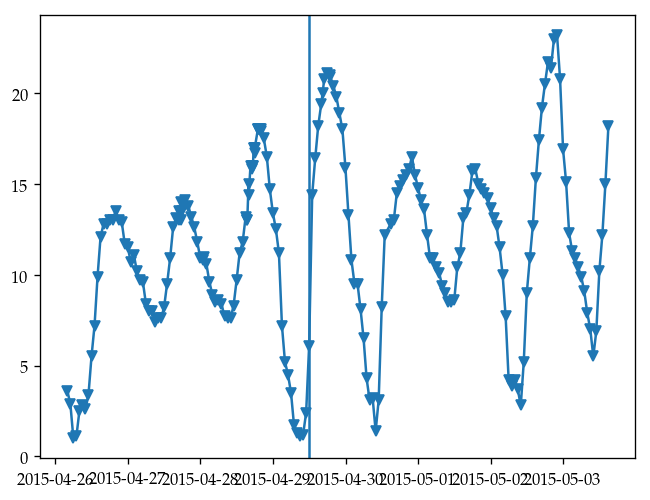

PyObject <matplotlib.lines.Line2D object at 0x14beb5ac8>

In [36]:
let
    icenter = 4942
    ts = station2[icenter-100:icenter+100,:ts]
    temp = station2[icenter-100:icenter+100,:temp]
    plt.plot(ts, temp, "-v")
    plt.axvline(station2[icenter,:ts])
end

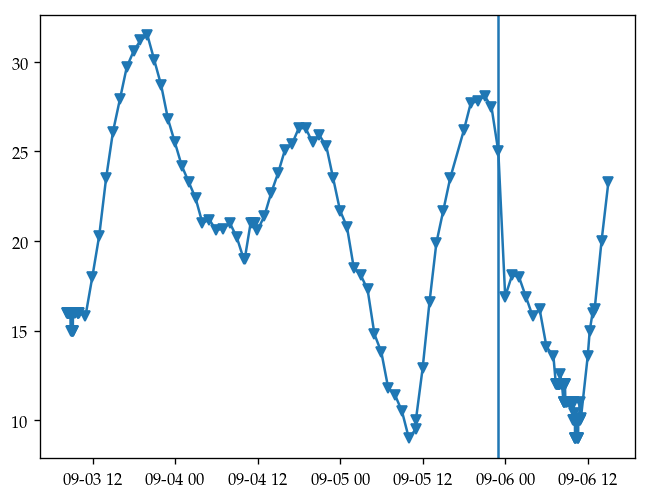

PyObject <matplotlib.lines.Line2D object at 0x14c592c50>

In [38]:
let
    icenter = 11833
    ts = station2[icenter-100:icenter+100,:ts]
    temp = station2[icenter-100:icenter+100,:temp]
    plt.plot(ts, temp, "-v")
    plt.axvline(station2[icenter,:ts])
end